In [1]:
from typing import Literal, Annotated, Union, Any
from langchain_openai import AzureChatOpenAI
from langgraph.graph import StateGraph, MessagesState, START, END
from langchain_core.messages import RemoveMessage
from langgraph.prebuilt import InjectedState
from langgraph.prebuilt import tools_condition
from IPython.display import Image, display
from langchain_core.messages import AIMessage, HumanMessage, SystemMessage, ToolMessage
from pydantic import BaseModel, Field
from prompts import SUPERVISOR_SYSTEM_PROMPTS
import operator
from langgraph.prebuilt import ToolNode

from langgraph.types import Command
from typing import DefaultDict
from typing import Callable, Any
from memory_tools import past_successful_example, rag_agent_tool, what_human_would_do
i=1

/Users/abhishek.kushwaha/.pyenv/versions/3.11.10/envs/lagent/lib/python3.11/site-packages/pinecone/data/index.py:1: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from tqdm.autonotebook import tqdm


here 4c8ef686-07c1-455e-aad8-f3d86969afcb jina_ea6fd31f2de447fbb177763473d35ba99s4j49M62chj1jYj2DZXwJdagP2e
JSON format is not enabled, normal log will be in plain text but request logging still in JSON format! To enable set ENABLE_JSON_LOGGING env var to either one of following values: ['true', '1', 'y', 'yes']


In [2]:
import sqlite3
# In memory
conn = sqlite3.connect(":memory:", check_same_thread = False)
from langgraph.checkpoint.sqlite import SqliteSaver
memory = SqliteSaver(conn)
memory_read_agent = SqliteSaver(conn)

In [4]:
from langgraph.graph.message import add_messages
from langchain_core.messages import AnyMessage
from typing_extensions import TypedDict

field_types = {
    "messages": Annotated[list[AnyMessage], add_messages],
    "merchant_profile": str,
    "latest_memory": str,
    "memory_message": Annotated[list[AnyMessage], add_messages],
    "last_message_from": Literal["memory_agent","read_agent", "tool", "other"],
    "read_agent_messages": Annotated[list[AnyMessage], add_messages],
    "update_agent_messages": Annotated[list[AnyMessage], add_messages]
}


ConversationState = TypedDict('ConversationState', field_types)


#what_human_would_do, get_billing_label_suggestions,toggle_fee_bearer,get_refund_source, 

tools = [past_successful_example ,
                            get_feature_status, 
                            get_merchant_config, 
                            
                            
							#update_refund_source,
							#get_bank_account_details_tool,
							#get_email_address_tool,
							#update_contact_name,
							#get_website_verification_status
                            ]
tool_model = model.bind_tools(tools, parallel_tool_calls=False)
memory_model = model.bind_tools([past_successful_example])





In [107]:
def create_memory_agent(name, tools, system_prompt, llm_model, graph_state):
    class AgentConfig(BaseModel):
        parent_agent_name: str = ""
        name: str = ""
        tools: list = []
        system_prompt: str = ""
        checkpointer: Any = None
        llm_model: Any = None
        graph_state: Any
        com_channel: str = "memory_message"
        msg_history: str = Literal["all", "last"]
    
    system_prompt = """You are an expert in retriving knowledge from external memory. You are part of customer support agent team and helps in getting best knowledge. You will be given a user message basis on that you will use your past_successful_example tool to get information which will help another agent to answer user query. 
    You are also given last knowledge you retrived. Since you are being called every time a user sends a message, it may be a case that previous knowledge is sufficeient enough to answer user new message and so there is no need to retrive new information and you can just answer no update required (do not add any comment). but if last knowledge seems incomplete to answer user message then retrive.
    ## user new message :  {user_message}
    ## last knowledge retrived : {latest_memory} """
    config = AgentConfig(name=name, tools=tools, system_prompt=system_prompt, llm_model=llm_model, graph_state=graph_state)
    def should_load_memory(state: config.graph_state, flash_memory_key: str = "latest_memory"):
        
        if state.get(flash_memory_key, ""):
                latest_memory = state[flash_memory_key]
        else:
                latest_memory = "No knowledge retrived yet"
        user_message = state["messages"][-1].content
        system_prompt = config.system_prompt.format(user_message=user_message, latest_memory=latest_memory)
        print("system_promot",system_prompt)
        response  = memory_model.invoke([SystemMessage(content=system_prompt)])
        print("response",response)
        return {"memory_message":[response]}
    
    def refresh_memory(state: config.graph_state, flash_memory_key: str = "latest_memory"):
        print("refresh state", state)
        last_mesage = state[config.com_channel][-1].copy()
        delete_messages = [RemoveMessage(id=m.id) for m in state[config.com_channel]]
        if isinstance(last_mesage, ToolMessage):

                #delete_messages = [RemoveMessage(id=m.id) for m in state["messages"][-1:]]
                dfdf = """Example 1 - Changing fee bearer
                Question : User wants to change their fee bearer.
                Step 1: ["Thought" : "I should first check the internal documents to understand the policies and process on how to update the fee bearer.",
                        "Tool used": past_successful_example]
                Step 2: ["Thought": "I now have the necessary information regarding the process and implications of changing the fee bearer. I will now check the current fee bearer status for the user and then proceed with the process of updating it if requested by the user."
                        "Tool used": get_merchant_config]
                Step 3: ["Thought": As per policy, changing the fee bearer to "customer" will disable certain features such as PayPal, Instant refunds, Route, Smart Collect, QR Codes, and Magic Checkout. Would you like to proceed with changing the fee bearer to "customer"? Please confirm so we can proceed with the necessary adjustments.,
                        "Tool used": finish_tool]
                Step 4: ["Thought" : As user has given permission to move ahead, I will go and check if all of the required service is disabled. first i will check 'route',
                        "Tool used" : get_feature_status]
                Step 5: ["Thought" : Route service is disabled, i will now check instant settlement,
                        "Tool used" : get_feature_status]
                Step 6: ["Thought" : Instant settlement service is disabled, i will now check Paypal,
                        "Tool used" : get_feature_status]
                Step 7: ["Thought" : Paypal service is active, i need to disable it if i have required tool but since I do not have the tool to disable it i will tranfer this issue to human agent by creating support ticket for changing fee bearer and they will disable everything and change fee bearer,
                        "Tool used" : CreateSupportTicket]
                Step 8: ["Final answer" : Since i do not have necessary permision to diable services, i have created a support ticket for you with reference number ####. They will diable all service and change your fee bearer to customer. This is be processed in 24-48 hours and you will recieve the confirmation on email.]


                Example 2 - Change fee bearer
                Question : User wants to change their fee bearer.
                Step 1: ["Thought" : "I should first check the internal documents to understand the policies and process on how to update the fee bearer.",
                        "Tool used": past_successful_example]
                Step 2: ["Thought": "I now have the necessary information regarding the process and implications of changing the fee bearer. I will now check the current fee bearer status for the user and then proceed with the process of updating it if requested by the user."
                        "Tool used": get_merchant_config]
                Step 3: ["Thought": Current merchant fee beareer setting is 'Customer' and as per policy there is no restrictions for changeing it to 'Platform' I will take user permission for chnage and then change it.,
                        "Tool used": finish_tool]
                Step 4: ["Thought" : As user has given permission to move ahead, I will go ahead and change fee bearer
                        "Tool used" : toggle_fee_bearer]
                Step 5: ["Final answer" : Your fee bearer has been update to Platform. Do you want Anythng else?]


                Example 3 - Account activation
                Question : Why my account is not activated yet
                Step 1: ["Thought" : "I need to check the policies and past experiences to understand the rules, regulations, and procedures for account activation delays.",
                        "Tool used": KnowledgeStore]
                Step 2: ["Thought": "The information retrieved does not directly address account activation delays. Therefore, I will check the past successful examples to understand how similar queries have been handled in the past."
                        "Tool used": PastSuccessfulExample]
                Step 3: ["Thought": The information retrieved from the PastSuccessfulExample indicates that there might be a need for further verification or there could be an issue with the account that requires internal team assistance. However, I should first check the current status of the website verification.,
                        "Tool used": GetWebsiteActivationStatus]
                Step 4: ["Final answer" : Your account activation is delayed because the "about_us", "privacy_policy", and "terms_and_conditions" sections of your website are not verified. Please complete these sections on your website to proceed with the account activation. If you need further assistance, feel free to ask.?]"""
                
                return {flash_memory_key: last_mesage.content + f'\n\n past successful execution steps for similar request: {dfdf}',
                        config.com_channel: delete_messages,
                        "last_message_from": "memory_agent"}
        else:
                return {config.com_channel: delete_messages,
                        "last_message_from": "memory_agent"}
    
    builder = StateGraph(config.graph_state)
    builder.add_node("should_load_memory", should_load_memory)
    builder.add_node("tools", ToolNode(config.tools, messages_key=config.com_channel))
    builder.add_node("memory_refresh", refresh_memory)

    builder.add_edge(START, "should_load_memory")
    builder.add_conditional_edges(
        "should_load_memory",
        # If the latest message (result) from assistant is a tool call -> tools_condition routes to tools
        # If the latest message (result) from assistant is a not a tool call -> tools_condition routes to END
        tools_condition,
        {"tools":"tools", END:"memory_refresh"}
        )
    builder.add_edge("tools", "memory_refresh")
    builder.add_edge("memory_refresh", END)
    memory_graph = builder.compile()
    return memory_graph
mmgpt = create_memory_agent("memory_agent", [past_successful_example], "", memory_model, ConversationState)

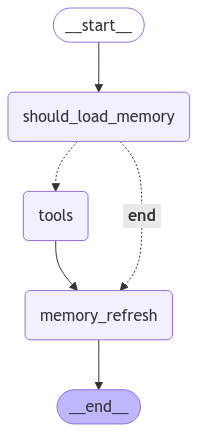

In [108]:
display(Image(mmgpt.get_graph(xray=True).draw_mermaid_png()))

In [26]:
from langgraph.prebuilt import create_react_agent
from trustcall import create_extractor
read_agent_system_msg = ("You are co-worker of Agent Ray and working in customer support industry." 
                         "You never communicate with the user but only with your co-worker."
                         "your job is execute a task given by your co-worker." 
                         "you have access to various tools. "
                         "use the best tool for the job and answer your co-worker question."
                         "If you do not have sufficient information for yout tool argument input then ask Ray to provide that."
                         )

def create_executor_agent(name, tools, system_prompt, checkpointer, llm_model, parent_agent_name, verifier_system_prompt=None):
    class AgentConfig(BaseModel):
        name: str = ""
        tools: list = []
        system_prompt: str = ""
        checkpointer: Any = None
        llm_model: Callable = None
        parent_agent_name: str = ""
        
    config = AgentConfig(name=name, tools=tools, system_prompt=system_prompt, checkpointer=checkpointer, llm_model=llm_model, parent_agent_name=parent_agent_name)
    base_agent = create_react_agent(llm_model,
                                                checkpointer=checkpointer,
                                                tools=tools, 
                                                state_modifier=system_prompt,
                            )
    
    class VerifierTask(BaseModel):
        update_task_name: str = Field(description="update the call setting to manual")
        update_task_required_presteps: list[str] = Field(description="list of the the policies pre-steps which need to be followed as per company policy before the current update. Never copy the examples e.g. ['check user current status', 'inform customer about potential impact','take user cinfirmation','check <placeholder 1> services to disable', 'check <placeholder 2> service to disable', 'disable <placeholder 1> service as it is currently enabled']")
        incomplete_presteps: list[str] = Field(description="list of the the policies pre-steps which need to be followed but planner agent missed it executing. Never copy the examples e.g. [<placeholder 1> service is not yet disabled.]")

    class verificationStatus(BaseModel):
        task_details: list[VerifierTask]
    
    if "update" in name.lower():
        verifier_agent = create_extractor(llm_model, tools=[verificationStatus], tool_choice="verificationStatus")
        

    def agent_node(state: ConversationState) -> Command[Literal[config.parent_agent_name]]:
        communication_channel = config.name + "_messages"
        msg = state[communication_channel][-1].content
        sender_channel = "messages"
        current_task = state[communication_channel][-1].content[state[communication_channel][-1].content.find("Task:"):]
        if "update" in name.lower():
            try:
                v_msg = "\n".join([m.name + " : " + m.content.replace('\n'," ") for m in state["messages"][:-1]])
            except:
                print("error", state["messages"])
                
            verifier_system_prompt = f"""
            You are an expert senior manager who oversees all the update which is going to happen in the system records.
            You are given the complete conversation of the planner agent who has planned a current update in the system.
            You will also be given the documents used by planner agent to understand all the policy.
            Your task is to verify that if the planner agent has taken all required policy into account and 
            also completed all the required pre steps which is to be completed
            before current system update can be done. Make sure all the individual policy related pre steps has been included.

            ## Current update task given by Manager
            {current_task}

            ## Here is the message history of the planer agent with others which you can use to verify if it has completed required steps.
            {v_msg}

            ## Here is the documents which Planner agent used to understand the policy which you can use to understand correct policy and verify planner agent has included and completed all required policy.
            {state["latest_memory"]}

            ## Points to note. 
            1. If there is mention of raising request via email or raising the request to concerned team then ignore such pre task.
            this is because about mentioned document is wriiten for customer to follow. but since we are part of customer support team 
            then we can take direct request if we have the tools to execute them. No need to raise request to customer support seperately.
            """
            verification_result = verifier_agent.invoke({"messages":[SystemMessage(content=verifier_system_prompt)]})["responses"][0]
            print("verification_result", verification_result)
            if len(verification_result.task_details[0].incomplete_presteps)>0:
                return Command(
                    update={
                        sender_channel: [
                            AIMessage(content=f"Coworker reply: Your request for the task {current_task} has not been fulfilled as i see that there are pre steps required which you need to execute before I can make any update. here are the list of task {verification_result.task_details[0].incomplete_presteps}. please complete these and then send the request for current task again.", name=config.name)
                        ],
                        "last_message_from": config.name
                    },
                    goto=config.parent_agent_name,
                )
        result = base_agent.invoke({"messages":msg}, debug=False)
        
        return Command(
            update={
                communication_channel: [
                    AIMessage(content="coworker reply: "+result["messages"][-1].content, name=config.name)
                ],
                sender_channel: [
                    AIMessage(content="coworker reply: "+result["messages"][-1].content, name=config.name)
                ],
                "last_message_from": config.name

            },
            # We want our workers to ALWAYS "report back" to the supervisor when done
            goto=config.parent_agent_name,
        )
    return agent_node
read_agent_node = create_executor_agent("read_agent",
                                        [get_merchant_config, get_feature_status, past_successful_example],
                                        read_agent_system_msg,
                                        memory_read_agent,
                                        model,
                                        "accounts_team")

update_agent_sys_msg = """you are a worker whose job is to execute the plan provided. 
                        you will be given a task by your manager with some details. you can execute your task using the tools provided to you. 
                        if you require any more information for tool input then you can ask your manager to provide more information. 
                        you should not give any comments but just the result or error of the execution.
                        If you do have have the right tool for the exection of the given task then reply that you do not have capability to do that particular task.
                        """
update_tools = [toggle_fee_bearer, update_refund_source]
update_agent_node = create_executor_agent("update_agent",
                                        update_tools,
                                        update_agent_sys_msg,
                                        memory_read_agent,
                                        model,
                                        "accounts_team")

In [27]:
import json
from typing import List, Tuple
from trustcall import create_extractor
def category_planner_node(llm, members: list[str]) -> str:
    
    class DelegateToCoworker(BaseModel):
        co_worker_name: str = Field(
            description="co-worker name to delegate"
        )
        co_worker_task: str = Field(
            description="Description and details of the current task co-worker has to execute. do not include description of the agent ability."
        )
        intermediate_response: str = Field(
            description=("We need to keep communicating with the user about. our conversation should not look mechanical."
                         "you can respond like 'ok let me check, please hold on for a moment' etc. Do not tell what exact process you are going to do. we nned not disclose internal working")
        )


    class Response(BaseModel):
        response: str = Field(..., description="response for sending it to next co-worker or user.")
    
    class Router(BaseModel):
        """Worker to route to next. If no workers needed, respond using Response."""

        thought: str = Field(..., description="reason for this step.")
        action: Union[DelegateToCoworker, Response] = Field(
            description="Action to perform. If you want to respond to user, use Response. "
            "If you need to further use tools to get the answer, use DelegateToCoworker."
        )
        
    trust_call_bound = create_extractor(llm, tools=[Router], tool_choice="Router")
    def planner_node(state: ConversationState) -> Command[Literal[*members, END]]:
        if state.get("merchant_profile",""):
            mechant_profile = state['merchant_profile']
            print("here")
        else:
            with open("merchant.md", 'r') as f:
                mechant_profile = f.read()
                state['merchant_profile'] = mechant_profile
        """An LLM-based router."""
        
        read_team = "Below are the abilites of your co-worker: " + " ".join(["\nAbility: "+str(i+1)+t.__doc__ for i,t in enumerate(tools)])
        write_team = "Below are the abilites of your co-worker: " + " ".join(["\nAbility: "+str(i+1)+t.__doc__ for i,t in enumerate(update_tools)])
        latest_memory = state.get("latest_memory", "")
        system_prompt = f"""Your are an expert manager and planner and your name is Ray. 
        You are working as customer support agent manager who creates plan for resolving user 
        query which other agents will execute. 
        There are co-workers who are working with you who can help you in executing your plan. You can 
        ask them to retrive information from the systems, retrive knowledge base information, and can also 
        perform update in the system when asked for. you have to plan the next step and delegate it to coworker agent to execute.
        only give one task at a time to the co-worker. 


        Here are the details of your co-workers and their abilitis.
        # Co-wroker 1 details:
        ## Name: read_agent
        ## Description: {read_team}

        # Co-wroker 2 details:
        ## Name: update_agent
        ## Description: {write_team}

        

        merchant_profile: {mechant_profile}
        latest_memory: {latest_memory}. refresh this if it is not sufficient.
        
        #instructions
        1. Use only these co-workers and do not make up co-workers. Do not plan if there is no co-workers available for that. Always plan for just next step as further step will depend on your planned step output. where ever required try to fetch current status of user as policy depends on current status.
        2. When you fetch the doc then since these docs are written for user or human agent, it may mention that 'internal team need to do something', in all such cases it may mean that you can do that something as you are the internal team if the tools are available otherwise leave it for another internal tema to execute.
        3. before updating anything in the system ask for user confirmation explicitly.
        4. When you give task to other AI agent then they will execute and reply back with result. They may also reply back with other task so you need to review and get it done by available agents. 
        """
        read_team_channel = "read_agent_messages"
        write_team_channel = "update_agent_messages"
        main_channel = "messages"
        messages = [
            {"role": "system", "content": system_prompt},
        ] + state[main_channel]
        #response = llm.with_structured_output(Router, strict=False).invoke(messages)
        response = trust_call_bound.invoke(messages)["responses"][0]
        if isinstance(response.action, DelegateToCoworker):
            itm_resp = response.action.intermediate_response
            if 'read' in response.action.co_worker_name.lower():
                if state["last_message_from"] == "memory_agent":
                    goto = ['read_agent', END]
                else:
                    goto = 'read_agent'
            else:
                if state["last_message_from"] == "memory_agent":
                    goto = ['update_agent', END]
                else:
                    goto = 'update_agent'
        if isinstance(response.action, Response):
            goto = END
        
        #goto = goto_map[response["tool_use"]]
        
        if goto == END:
            return Command(
            update={
                main_channel: [
                    AIMessage(
                        content="Thought: " + response.thought+ "\nresponse: " + response.action.response, name="planner"
                    )
                ],
                "last_message_from":"supervisor1"
            },
            goto=END)
        elif "read_agent" in goto:
            return Command(
            update={read_team_channel:
                [AIMessage(
                    content="Thought: " + response.thought+ "\ncoworker_name: " + response.action.co_worker_name + "\nTask:" + response.action.co_worker_task, name="planner"
                ) ],
                "last_message_from":"supervisor2",
                "messages": [AIMessage(
                    content="Thought: " + response.thought+ "\ncoworker_name: " + response.action.co_worker_name + "\nTask:" + response.action.co_worker_task, name="planner"
                )] +
                ([AIMessage(content=itm_resp, name="planner")] if state["last_message_from"]=='memory_agent' else []),
            },
            goto=goto
            )
        else:
            return Command(
            update={write_team_channel:
                [AIMessage(
                    content="Thought: " + response.thought+ "\ncoworker_name:"  + response.action.co_worker_name + "\nTask: " + response.action.co_worker_task, name="planner"
                ) ],
                "last_message_from":"supervisor3",
                "messages": [AIMessage(
                    content="Thought: " + response.thought+ "\ncoworker_name:"  + response.action.co_worker_name + "\nTask: " + response.action.co_worker_task, name="planner"
                )]+ 
                ([AIMessage(content=itm_resp, name="planner")] if state["last_message_from"]=='memory_agent' else []),
            },
            goto=goto
            )

        return 


    return planner_node

In [28]:
accounts_team_node = category_planner_node(model, ["read_agent", "update_agent"])

In [29]:
# Define the graph.
super_builder = StateGraph(ConversationState)
super_builder.add_node("memory_graph", mmgpt)
super_builder.add_node("accounts_team", accounts_team_node)
super_builder.add_node("read_agent", read_agent_node)
super_builder.add_node("update_agent", update_agent_node)


super_builder.add_edge(START, "memory_graph")
super_builder.add_edge("memory_graph", "accounts_team")
super_graph = super_builder.compile(checkpointer=memory)

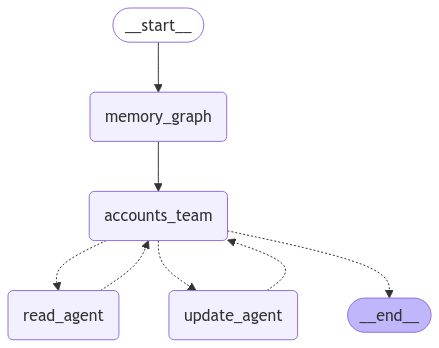

In [30]:
from IPython.display import Image, display

display(Image(super_graph.get_graph(xray=False).draw_mermaid_png()))

In [31]:
i+=1
config = {"configurable": {"thread_id": f"{i}"}}
messages = {"messages":[HumanMessage(content="i want to update my contact name",name="human")]}
for stream_output in super_graph.stream(messages, config, debug=False):
    print(stream_output)


system_promot You are an expert in retriving knowledge from external memory. You are part of customer support agent team and helps in getting best knowledge. You will be given a user message basis on that you will use your past_successful_example tool to get information which will help another agent to answer user query. 
    You are also given last knowledge you retrived. Since you are being called every time a user sends a message, it may be a case that previous knowledge is sufficeient enough to answer user new message and so there is no need to retrive new information and you can just answer no update required (do not add any comment). but if last knowledge seems incomplete to answer user message then retrive.
    ## user new message :  i want to update my contact name
    ## last knowledge retrived : No knowledge retrived yet 
response content='' additional_kwargs={'tool_calls': [{'id': 'call_wyREkVAUcrLIEJ58yp7mrv9P', 'function': {'arguments': '{"query":"update contact name","tho

KeyError: 'last_message_from'

In [49]:
"""for m in super_graph.get_state(config).values["messages"]:
    m.pretty_print()"""

'for m in super_graph.get_state(config).values["messages"]:\n    m.pretty_print()'

In [18]:
messages = {"messages":[HumanMessage(content="how to update fee bearer ",name="human")]}
for stream_output in super_graph.stream(messages, config, debug=False):
    print(stream_output)

system_promot You are an expert in retriving knowledge from external memory. You are part of customer support agent team and helps in getting best knowledge. You will be given a user message basis on that you will use your past_successful_example tool to get information which will help another agent to answer user query. 
    You are also given last knowledge you retrived. Since you are being called every time a user sends a message, it may be a case that previous knowledge is sufficeient enough to answer user new message and so there is no need to retrive new information and you can just answer no update required (do not add any comment). but if last knowledge seems incomplete to answer user message then retrive.
    ## user new message :  how to update fee bearer 
    ## last knowledge retrived : Error: ConnectError('[Errno 61] Connection refused')
 Please fix your mistakes.

 past successful execution steps for similar request: Example 1 - Changing fee bearer
                Questio

In [39]:
#super_graph.get_state(config).values["messages"]

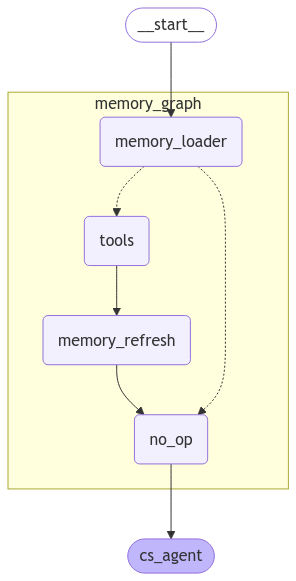

In [88]:
import json

def cs_agent(state: ConversationState):
    if state.get("merchant_profile",""):
        mechant_profile = state['merchant_profile']
        print("here")
    else:
        with open("merchant.md", 'r') as f:
            mechant_profile = f.read()
            state['merchant_profile'] = mechant_profile
    latest_memory = state.get("latest_memory", "")



    tool_des_map = {t.__name__:{"description": t.__doc__, "arguments":t.__annotations__} for t in tools}
    msg = f"""Your are an expert manager and planner. You are working as customer support agent manager who creates plan for resolving user query which other agents will execute. To be able to correctly plan, you have access to merchnat profile and our company context via tools. 
    here is the list of tools and description:
    {tool_des_map}.
    confirm_with_customer_tool: when we need to inform anything or communicate anythong to customer use this tool for planning 
    placeholder_tool: when the future step is going to be based on the output of previous steps & respective policy etc then use this tool to show that future planning will be done later. this should always be last tool inthe plan. no other tool can be used after this


    merchant_profile: {mechant_profile}
    latest_memory: {latest_memory}
    
    Use only these tools and do not make up tools. Do not plan if there is no tools available for that. Always plan for just next step as further step will depend on your planned step output. where ever required try to fetch current status of user as policy depends on current status.
    Output the plan in this given format:
    
    {json.dumps({"next_step": {"thought":"reason for this step.", "tool_use": "name of tool to use", "tool_args": "arguments for the tools.", "policy_rules":"mention the policy which you have checked which is applicable to this action as per user current state. if this step is not about updating anything in the system then reply 'na'"}})} """
    supervisor_system_message = SystemMessage(content=msg)
    response = model.invoke([supervisor_system_message]+state["messages"])
    
    # the "next" key will be used by the conditional edges to route execution
    # to the appropriate agent
    return {"messages":[response], "next": json.loads(response.content)["next_step"]["tool_use"]}


def should_continue(state: ConversationState):
    next = state["next"]
    return next.upper()


new_builder = StateGraph(ConversationState)
new_builder.add_node("memory_graph", memory_graph)
new_builder.add_node("cs_agent", cs_agent)

new_builder.add_edge(START, "memory_graph")
new_builder.add_edge("memory_graph", "cs_agent")
cs_graph = new_builder.compile(checkpointer=memory)
display(Image(cs_graph.get_graph(xray=True).draw_mermaid_png()))

In [89]:

config = {"configurable": {"thread_id": f"{i}"}}
messages = {"messages":"i need to update my fee bearer"}
for stream_output in cs_graph.stream(messages, config):
    print(stream_output)
i+=1

{'memory_graph': {'messages': [HumanMessage(content='i need to update my fee bearer', additional_kwargs={}, response_metadata={}, id='69f9756d-bf8c-420a-b65a-61854b8143a7'), AIMessage(content='tool_name:Read_team\n{"context": "details about the task to be executed and required information which is needed"}', additional_kwargs={}, response_metadata={}, name='planner', id='a57ed14e-02b6-48a8-b0cc-2ef466334f8e'), AIMessage(content='{"brand_color": "#808080", "logo_url": null, "display_name": null, "fee_bearer": "customer"}', additional_kwargs={}, response_metadata={}, name='read_agent_node', id='96779f6e-d948-40cd-8a8e-f07114f47561'), AIMessage(content="The current fee bearer setting for your account is 'customer'. Would you like to change it to 'platform'? Please confirm so we can proceed with the necessary adjustments.", additional_kwargs={}, response_metadata={}, name='planner', id='581f5878-6a03-436e-84b5-2a4a7f5a7030'), HumanMessage(content='yes', additional_kwargs={}, response_metad

In [90]:
messages = {"messages":"current is credits"}
for stream_output in cs_graph.stream(messages, config):
    print(stream_output)

{'memory_graph': {'messages': [HumanMessage(content='i need to update my fee bearer', additional_kwargs={}, response_metadata={}, id='69f9756d-bf8c-420a-b65a-61854b8143a7'), AIMessage(content='tool_name:Read_team\n{"context": "details about the task to be executed and required information which is needed"}', additional_kwargs={}, response_metadata={}, name='planner', id='a57ed14e-02b6-48a8-b0cc-2ef466334f8e'), AIMessage(content='{"brand_color": "#808080", "logo_url": null, "display_name": null, "fee_bearer": "customer"}', additional_kwargs={}, response_metadata={}, name='read_agent_node', id='96779f6e-d948-40cd-8a8e-f07114f47561'), AIMessage(content="The current fee bearer setting for your account is 'customer'. Would you like to change it to 'platform'? Please confirm so we can proceed with the necessary adjustments.", additional_kwargs={}, response_metadata={}, name='planner', id='581f5878-6a03-436e-84b5-2a4a7f5a7030'), HumanMessage(content='yes', additional_kwargs={}, response_metad

In [91]:
for m in cs_graph.get_state(config).values["messages"]:
    m.pretty_print()

================================ Human Message =================================

i need to update my fee bearer
================================== Ai Message ==================================
Name: planner

tool_name:Read_team
{"context": "details about the task to be executed and required information which is needed"}
================================== Ai Message ==================================
Name: read_agent_node

{"brand_color": "#808080", "logo_url": null, "display_name": null, "fee_bearer": "customer"}
================================== Ai Message ==================================
Name: planner

The current fee bearer setting for your account is 'customer'. Would you like to change it to 'platform'? Please confirm so we can proceed with the necessary adjustments.
================================ Human Message =================================

yes
================================== Ai Message ==================================
Name: planner

tool_name:Write_team
{"context"

In [92]:
cs_graph.get_state(config).values

{'messages': [HumanMessage(content='i need to update my fee bearer', additional_kwargs={}, response_metadata={}, id='69f9756d-bf8c-420a-b65a-61854b8143a7'),
  AIMessage(content='tool_name:Read_team\n{"context": "details about the task to be executed and required information which is needed"}', additional_kwargs={}, response_metadata={}, name='planner', id='a57ed14e-02b6-48a8-b0cc-2ef466334f8e'),
  AIMessage(content='{"brand_color": "#808080", "logo_url": null, "display_name": null, "fee_bearer": "customer"}', additional_kwargs={}, response_metadata={}, name='read_agent_node', id='96779f6e-d948-40cd-8a8e-f07114f47561'),
  AIMessage(content="The current fee bearer setting for your account is 'customer'. Would you like to change it to 'platform'? Please confirm so we can proceed with the necessary adjustments.", additional_kwargs={}, response_metadata={}, name='planner', id='581f5878-6a03-436e-84b5-2a4a7f5a7030'),
  HumanMessage(content='yes', additional_kwargs={}, response_metadata={}, i

In [93]:
cs_graph.get_state(config)

StateSnapshot(values={'messages': [HumanMessage(content='i need to update my fee bearer', additional_kwargs={}, response_metadata={}, id='69f9756d-bf8c-420a-b65a-61854b8143a7'), AIMessage(content='tool_name:Read_team\n{"context": "details about the task to be executed and required information which is needed"}', additional_kwargs={}, response_metadata={}, name='planner', id='a57ed14e-02b6-48a8-b0cc-2ef466334f8e'), AIMessage(content='{"brand_color": "#808080", "logo_url": null, "display_name": null, "fee_bearer": "customer"}', additional_kwargs={}, response_metadata={}, name='read_agent_node', id='96779f6e-d948-40cd-8a8e-f07114f47561'), AIMessage(content="The current fee bearer setting for your account is 'customer'. Would you like to change it to 'platform'? Please confirm so we can proceed with the necessary adjustments.", additional_kwargs={}, response_metadata={}, name='planner', id='581f5878-6a03-436e-84b5-2a4a7f5a7030'), HumanMessage(content='yes', additional_kwargs={}, response_m